In [2]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from lightgbm import LGBMClassifier

# 準備

In [34]:
"""データの読込"""
# 欠損値ありデータ
# train_df = pd.read_csv("../data/train.csv", index_col=0)
# test_df  = pd.read_csv("../data/test.csv", index_col=0)

# 欠損値なしデータ
train_df = pd.read_csv("../data/train_imputed_with_lgbm.csv", index_col=0)
test_df  = pd.read_csv("../data/test_imputed_with_lgbm.csv", index_col=0)

test_df.head()

,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
40785,2,0.1543,225.68,16525.86,22.39,668,1960,43771.0,59.3,3,0,0
40786,2,0.1539,200.43,62412.73,21.84,660,5958,13607.0,87.0,1,1,0
40787,2,0.1503,252.35,42836.79,21.77,663,4950,1832.0,36.8,5,0,1
40788,2,0.1316,533.85,27821.44,10.60,690,1825,3597.0,60.0,0,0,0
40789,2,0.1506,484.50,91406.09,17.35,658,3253,12137.0,48.8,1,0,0


In [35]:
"""データの基本情報"""

print(f"訓練データセットの形状： {train_df.shape}")
print(f"テストデータセットの形状： {test_df.shape}")

print()
print("===基本統計量===")
print("<訓練データセット>")
display(train_df.describe())
print("<最終テストデータセット>")
display(test_df.describe())


print()
print("===要約情報===")
print("<訓練データセット>")
display(train_df.info())
print("<最終テストデータセット>")
display(test_df.info())

訓練データセットの形状： (40785, 13)
テストデータセットの形状： (40786, 12)

===基本統計量===
<訓練データセット>


,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,40785.000000,40785.000000,40785.000000,4.078500e+04,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000,40785.000000
mean,2.747628,0.125414,302.319235,7.087001e+04,12.530579,709.393061,4736.481746,15426.025468,46.161957,1.543018,0.180998,0.039696,0.151870
std,1.986736,0.030167,208.058959,6.524275e+04,6.831929,39.299297,2568.216636,22343.495560,28.258810,2.059082,0.513544,0.195246,0.358899
min,0.000000,0.060800,15.680000,2.086720e+03,0.110000,615.000000,179.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.105300,157.400000,3.868640e+04,6.700000,679.000000,2965.000000,3433.000000,22.500000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.125200,241.120000,5.862029e+04,12.740000,703.000000,4304.000000,8441.000000,44.500000,1.000000,0.000000,0.000000,0.000000
75%,4.000000,0.145100,391.990000,8.416863e+04,17.930000,737.000000,5896.000000,19085.000000,68.900000,2.000000,0.000000,0.000000,0.000000
max,6.000000,0.800000,939.380000,1.913363e+06,29.930000,826.000000,16888.000000,356328.000000,108.300000,14.000000,3.000000,1.000000,1.000000


<最終テストデータセット>


,purpose,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec
count,40786.000000,40786.00000,40786.000000,4.078600e+04,40786.000000,40786.000000,40786.000000,40786.000000,40786.00000,40786.00000,40786.000000,40786.000000
mean,2.758888,0.12544,300.571366,7.019006e+04,12.552485,709.242338,4685.578556,15249.182289,46.41177,1.52876,0.179694,0.038739
std,1.980095,0.03087,208.171846,6.145846e+04,6.836684,39.320390,2540.021093,22272.133847,28.32093,2.08263,0.513398,0.192974
min,0.000000,0.06160,15.680000,2.128340e+03,0.090000,616.000000,181.000000,1.000000,0.10000,0.00000,0.000000,0.000000
25%,1.000000,0.10540,155.790000,3.855412e+04,6.700000,679.000000,2928.250000,3367.000000,23.00000,0.00000,0.000000,0.000000
50%,2.000000,0.12510,240.400000,5.814888e+04,12.760000,704.000000,4253.000000,8258.000000,44.70000,1.00000,0.000000,0.000000
75%,4.000000,0.14510,388.415000,8.379708e+04,17.950000,736.750000,5834.000000,18686.750000,69.10000,2.00000,0.000000,0.000000
max,6.000000,0.90000,938.860000,2.000790e+06,29.950000,826.000000,17416.000000,296156.000000,109.60000,14.00000,3.000000,1.000000



===要約情報===
<訓練データセット>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40785 entries, 0 to 40784
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purpose            40785 non-null  int64  
 1   int.rate           40785 non-null  float64
 2   installment        40785 non-null  float64
 3   annual.inc         40785 non-null  float64
 4   dti                40785 non-null  float64
 5   fico               40785 non-null  int64  
 6   days.with.cr.line  40785 non-null  int64  
 7   revol.bal          40785 non-null  float64
 8   revol.util         40785 non-null  float64
 9   inq.last.6mths     40785 non-null  int64  
 10  delinq.2yrs        40785 non-null  int64  
 11  pub.rec            40785 non-null  int64  
 12  not.fully.paid     40785 non-null  int64  
dtypes: float64(6), int64(7)
memory usage: 4.4 MB


None

<最終テストデータセット>
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40786 entries, 40785 to 81570
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   purpose            40786 non-null  int64  
 1   int.rate           40786 non-null  float64
 2   installment        40786 non-null  float64
 3   annual.inc         40786 non-null  float64
 4   dti                40786 non-null  float64
 5   fico               40786 non-null  int64  
 6   days.with.cr.line  40786 non-null  int64  
 7   revol.bal          40786 non-null  float64
 8   revol.util         40786 non-null  float64
 9   inq.last.6mths     40786 non-null  int64  
 10  delinq.2yrs        40786 non-null  int64  
 11  pub.rec            40786 non-null  int64  
dtypes: float64(6), int64(6)
memory usage: 4.0 MB


None

# 前処理

In [36]:
"""欠損値のある行の削除"""
print(f"欠損値前の訓練/テストデータの形状：{train_df.shape}")

# 欠損値の削除
train_df_drop = train_df.dropna()

print(f"欠損値後の訓練/テストデータの形状：{train_df_drop.shape}")

欠損値前の訓練/テストデータの形状：(40785, 13)
欠損値後の訓練/テストデータの形状：(40785, 13)


In [6]:
"""テストデータの欠損値は中央値で補完"""

test_df["purpose"].fillna(test_df["purpose"].mode()[0], inplace=True)
test_df['installment'].fillna(test_df["installment"].median(), inplace=True)
test_df['revol.bal'].fillna(test_df["revol.bal"].median(), inplace=True)
test_df['revol.util'].fillna(test_df["revol.util"].median(), inplace=True)

In [37]:
"""カテゴリカル変数（purpose）のエンコーディング"""
# "purpose"列をone-hotエンコーディング
train_df_encoded = pd.get_dummies(train_df_drop, columns=['purpose'], prefix='purpose')
test_df_encoded = pd.get_dummies(test_df, columns=['purpose'], prefix='purpose')

display(train_df_encoded.head())

,int.rate,installment,annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_0,purpose_1,purpose_2,purpose_3,purpose_4,purpose_5,purpose_6
0,0.1691,652.10,29579.74,10.66,730,3333,4955.0,39.6,4,2,0,1,0,0,0,0,0,0,1
1,0.1354,191.27,52808.95,13.06,707,6063,12335.0,37.8,2,1,0,0,0,0,0,0,0,1,0
2,0.0758,377.00,168689.22,11.98,736,2681,1505.0,5.0,1,0,0,0,0,1,0,0,0,0,0
3,0.1774,359.33,71325.19,20.55,702,3972,39536.0,94.1,1,0,0,0,0,0,1,0,0,0,0
4,0.1430,875.45,130773.88,17.61,688,5555,17295.0,56.4,0,0,0,0,0,1,0,0,0,0,0


In [38]:
"""データの分割"""

# 説明変数/目的変数の分割
X = train_df_encoded.drop(columns=["not.fully.paid"])
y = train_df_encoded["not.fully.paid"]

# 訓練/テストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# モデルの構築

## LightGMB

In [45]:
"""GridSearchCVでパラメータチューニングを行う"""

# チューニングするパラメータ
params = {
    "n_estimators": [280, 300, 330],
    "num_leaves": [10],
    "learning_rate": [0.05],
    "verbosity": [-1],
}

# インスタンスの作成
lgbm = LGBMClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=params,
    cv=10,
    scoring="roc_auc"
)

# モデルの訓練
grid_search.fit(X_train, y_train)
print(f"最適なパラメータ: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

# 予測確率の計算
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

最適なパラメータ: {'learning_rate': 0.05, 'n_estimators': 300, 'num_leaves': 10, 'verbosity': -1}


In [58]:
# 閾値0.6を使用して予測ラベルを生成
threshold = 0.2
y_pred_custom_threshold = (y_pred_prob >= threshold).astype(int)

# AUCスコアの計算
custom_auc = roc_auc_score(y_test, y_pred_custom_threshold)

# 結果の表示
print(f"AUC Score with custom threshold 0.5: {custom_auc:.2f}")
print("\nClassification Report with custom threshold 0.5:")
print(classification_report(y_test, y_pred_custom_threshold))

AUC Score with custom threshold 0.5: 0.72

Classification Report with custom threshold 0.5:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     10378
           1       0.36      0.64      0.46      1858

    accuracy                           0.77     12236
   macro avg       0.64      0.72      0.66     12236
weighted avg       0.84      0.77      0.80     12236



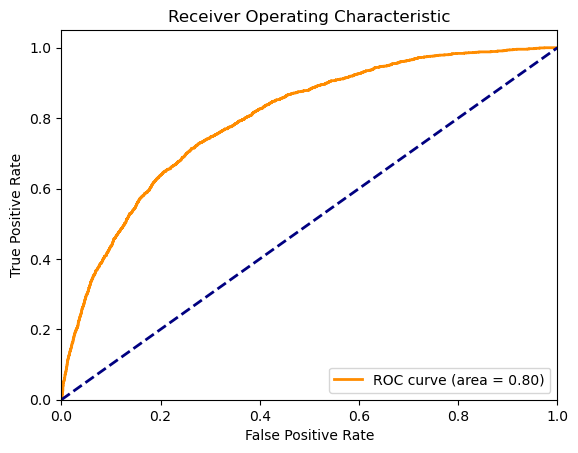

Classification Report with custom threshold:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     10378
           1       0.36      0.64      0.46      1858

    accuracy                           0.77     12236
   macro avg       0.64      0.72      0.66     12236
weighted avg       0.84      0.77      0.80     12236



In [60]:
"""予測確率に対する閾値の設定"""

# ROC曲線の描画とAUCの計算
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# 適切な閾値の決定（例として0.4を使用）
threshold = 0.2
y_pred_custom_threshold = (y_pred_prob >= threshold).astype(int)

# 結果の表示
print("Classification Report with custom threshold:")
print(classification_report(y_test, y_pred_custom_threshold))

# 提出

In [61]:
y_pred_prob = best_model.predict_proba(test_df_encoded)[:, 1]

threshold = 0.2
y_pred_custom_threshold = (y_pred_prob >= threshold).astype(int)

In [62]:
# データフレームの作成
submit = pd.DataFrame(data=y_pred_custom_threshold, index=test_df_encoded.index)

# 今日の日付の取得
today = datetime.datetime.now()
formatted_date = today.strftime("%Y%m%d")

filename = "../output/" + formatted_date + ".csv"


# csvファイルの出力
submit.to_csv(filename, index=True, header=False)